In [1]:
import pandas
import copy
import geopandas
import numpy

from shapely.geometry import Point

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

import cryptic_ecoffs

%load_ext autoreload
%autoreload 2

pandas.options.display.max_columns=100

local_tables = 'tables/'

# Load the base tables

In [2]:
UKMYC_PHENOTYPES = pandas.read_csv(local_tables+"UKMYC_PHENOTYPES.csv.gz", dtype={'SITEID':str})
UKMYC_PHENOTYPES.set_index(['UNIQUEID'], inplace=True)

GENOMES = pandas.read_csv(local_tables+'GENOMES.csv.gz', dtype={'SITEID':str})
GENOMES.set_index(['UNIQUEID'], inplace=True)

UKMYC_PLATES=pandas.read_csv(local_tables+"UKMYC_PLATES.csv.gz", dtype={'SITEID':'str'})
UKMYC_PLATES.set_index(['UNIQUEID'], inplace=True)

MUTATIONS=pandas.read_csv(local_tables+'MUTATIONS.csv.gz', dtype={'SITEID':str})
MUTATIONS.set_index(['UNIQUEID'], inplace=True)

DST_MEASUREMENTS=pandas.read_csv(local_tables+'DST_MEASUREMENTS.csv.gz', dtype={'SITEID':str})
DST_MEASUREMENTS.set_index(['UNIQUEID'], inplace=True)

COUNTRIES_LOOKUP=pandas.read_csv(local_tables+'COUNTRIES_LOOKUP.csv')
COUNTRIES_LOOKUP.set_index('COUNTRY_CODE_3_LETTER',inplace=True)

WORLD_MAP=geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
WORLD_MAP=WORLD_MAP.loc[WORLD_MAP.continent!="Antarctica"]
WORLD_MAP.set_index('iso_a3',inplace=True)

SITES=pandas.read_csv(local_tables+'SITES.csv',dtype={'SITEID':str})

PLATE_LAYOUT=pandas.read_csv(local_tables+'PLATE_LAYOUT.csv')
PLATE_LAYOUT.set_index(['PLATEDESIGN', 'DRUG', 'DILUTION'], inplace=True)

plate_designs=['UKMYC6','UKMYC5']

plate_design_lookup={}

for plate_design in plate_designs:

    plate_design_lookup[plate_design]={'INH':[plate_design],
                        'RIF':[plate_design],
                        'EMB':[plate_design],
                        'AMI':[plate_design],
                        'KAN':[plate_design],
                        'MXF':[plate_design],
                        'LEV':[plate_design],
                        'ETH':[plate_design],
                        'RFB':[plate_design],
                        'LZD':[plate_design],
                        'CFZ':[plate_design],
                        'BDQ':[plate_design],
                        'DLM':[plate_design],
                        'PAS':[plate_design]}

# Figure 1

In [3]:
UKMYC_PLATES.SITEID.unique()

array(['11', '01', '02', '03', '04', '05', '06', '08', '10', '13', '14',
       '16', '17', '20'], dtype=object)

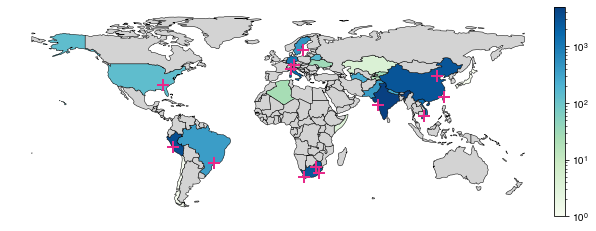

In [4]:
table=[]
for idx,row in SITES.iterrows():
    foo=[]
    if isinstance(row['CITY'],str):
        if row['SITEID'] in UKMYC_PLATES.SITEID.unique():
            foo.append(row['CITY'])
            foo.append(row['COUNTRY_3_LETTER_CODE'])
            foo.append(Point(row['LONG'],row['LAT']))
            table.append(foo)

CITIES=geopandas.GeoDataFrame(table,columns=['City','Country','geometry'])
CITIES=CITIES.set_geometry('geometry')
CITIES['PLOT_COUNTRY']=True
CITIES.set_index('Country',inplace=True)

COUNTRIES_WITH_SAMPLES=UKMYC_PLATES.COUNTRY_CODE.value_counts()
COUNTRIES_WITH_SAMPLES=COUNTRIES_WITH_SAMPLES.to_frame()
COUNTRIES_WITH_SAMPLES.rename(columns={'COUNTRY_CODE':'SAMPLES'},inplace=True)
COUNTRIES_WITH_SAMPLES=COUNTRIES_WITH_SAMPLES.join(COUNTRIES_LOOKUP[['COUNTRY_NAME']])

MAP=WORLD_MAP.join(COUNTRIES_WITH_SAMPLES,how='left')

figure,axes = plt.subplots(figsize=(10,5))

divider=make_axes_locatable(axes)
cax=divider.append_axes('right',size="2%",pad='1%') 

MAP.plot(column='SAMPLES',ax=axes,cmap='GnBu',edgecolor='black',cax=cax,linewidth=0.5,legend=True,norm=matplotlib.colors.LogNorm(vmin=1, vmax=MAP['SAMPLES'].max()),missing_kwds= {'color':"lightgrey"})
        
CITIES.plot(ax=axes,marker='+',color='#e7298a',markersize=150,linewidth=2)

axes.axis('off')

figure.savefig("graphs/map-samples+sites.pdf",transparent=True)

# Table 1

In [5]:
line="%50s %10s %10s %10s" % ('','Total','UKMYC6','UKMYC5')
print(line)

df=UKMYC_PLATES
line="%50s %10i %10i %10i" % ("Samples collected",len(df),len(df.loc[df.PLATEDESIGN=='UKMYC6']),len(df.loc[df.PLATEDESIGN=='UKMYC5']))
print(line)

df=UKMYC_PLATES.loc[(UKMYC_PLATES.TRUST_PHENOTYPES)]
line="%50s %10i %10i %10i" % ("Readable plates",len(df),len(df.loc[df.PLATEDESIGN=='UKMYC6']),len(df.loc[df.PLATEDESIGN=='UKMYC5']))
print(line)

df=UKMYC_PLATES.loc[(UKMYC_PLATES.TRUST_PHENOTYPES) & (UKMYC_PLATES.IM_WELLS_IDENTIFIED) & (~UKMYC_PLATES.DUPLICATED_IMAGE)]
line="%50s %10i %10i %10i" % ("Readable plates with images",len(df),int(len(df.loc[df.PLATEDESIGN=='UKMYC6'])),int(len(df.loc[df.PLATEDESIGN=='UKMYC5'])))
print(line)

df=UKMYC_PLATES.loc[(UKMYC_PLATES.TRUST_PHENOTYPES) & (UKMYC_PLATES.BELONGS_GPI)]
line="%50s %10i %10i %10i" % ("Readable plates with genetics",len(df),len(df.loc[df.PLATEDESIGN=='UKMYC6']),len(df.loc[df.PLATEDESIGN=='UKMYC5']))
print(line)

df=UKMYC_PLATES.loc[(UKMYC_PLATES.TRUST_PHENOTYPES) & (UKMYC_PLATES.IM_WELLS_IDENTIFIED) & (~UKMYC_PLATES.DUPLICATED_IMAGE) & (UKMYC_PLATES.BELONGS_GPI)]
line="%50s %10i %10i %10i" % ("Readable plates with genetics and images",int(len(df)),int(len(df.loc[df.PLATEDESIGN=='UKMYC6'])),int(len(df.loc[df.PLATEDESIGN=='UKMYC5'])))
print(line)

df=UKMYC_PHENOTYPES.loc[UKMYC_PHENOTYPES.IS_RAW]
line="%50s %10i %10i %10i" % ("Readable plates with images, QA",int(len(df)/13),int(len(df.loc[df.PLATEDESIGN=='UKMYC6'])/13),int(len(df.loc[df.PLATEDESIGN=='UKMYC5'])/13))
print(line)

df=UKMYC_PHENOTYPES.loc[(UKMYC_PHENOTYPES.IS_RAW) & (UKMYC_PHENOTYPES.PHENOTYPE_QUALITY=='HIGH') & (UKMYC_PHENOTYPES.BELONGS_GPI)]
line="%50s %10i %10i %10i" % ("Readable plates with genetics, images, QA",int(len(df)/13),int(len(df.loc[df.PLATEDESIGN=='UKMYC6'])/13),int(len(df.loc[df.PLATEDESIGN=='UKMYC5'])/13))
print(line)

df=UKMYC_PHENOTYPES.loc[(UKMYC_PHENOTYPES.IS_RAW) & (UKMYC_PHENOTYPES.index.isin(GENOMES.loc[GENOMES.IS_SSSSnotR_clean].index.unique()))]
line="%50s %10i %10i %10i" % ("Readable plates with genetics, images, QA, gWT",int(len(df)/13),int(len(df.loc[df.PLATEDESIGN=='UKMYC6'])/13),int(len(df.loc[df.PLATEDESIGN=='UKMYC5'])/13))
print(line)


                                                        Total     UKMYC6     UKMYC5
                                 Samples collected      20637      12672       7965
                                   Readable plates      17054      10010       7044
                       Readable plates with images      15138       9272       5866
                     Readable plates with genetics      12362       6019       6343
          Readable plates with genetics and images      10938       5552       5386
                   Readable plates with images, QA      11801       6896       4904
         Readable plates with genetics, images, QA       8553       4027       4526
    Readable plates with genetics, images, QA, gWT       3328       1606       1722


# Table S1 - samples collected by laboratory

In [6]:
UKMYC_PLATES.reset_index(inplace=True)
UKMYC_PLATES.set_index('SITEID',inplace=True)
SITES.reset_index(inplace=True)
SITES.set_index('SITEID',inplace=True)

df=UKMYC_PLATES.join(SITES,how="left")
UKMYC_PLATES.reset_index(inplace=True)
UKMYC_PLATES.set_index('UNIQUEID',inplace=True)

df['Plate Design']=df.PLATEDESIGN
df['Laboratory']=df.DESCRIPTION
df['Location']=df.COUNTRY

TABLE=pandas.crosstab([df['Laboratory'],df['Location']],df['Plate Design'],margins=True,margins_name="Total") #.to_latex(escape=True,column_format="llrrr",columns=["Total","UKMYC5","UKMYC6"],index=True)
TABLE

,Plate Design,UKMYC5,UKMYC6,Total
Laboratory,Location,,,
African Health Research Institute,South Africa,0,124,124
Brazil,Brazil,68,300,368
Centers for Disease Control and Prevention,United States,1,135,136
"Centre for Tuberculosis, NICD",South Africa,895,1017,1912
Chinese Center for Disease Control and Prevention,China,1409,1359,2768
Hinduja Hospital and Foundation for Medical Research Mumbai,India,2327,2665,4992
Institute of Microbiology and Laboratory Medicine,Germany,104,1669,1773
Oxford University Clinical Research Unit,Vietnam,679,830,1509
Public Health Sweden,Sweden,100,357,457


In [7]:
print(str(len(df['Laboratory'].unique()))+" CRyPTIC laboratories based in "+str(len(df['Location'].unique()))+" countries")

14 CRyPTIC laboratories based in 11 countries


# Tables S2 - samples collected by country

In [8]:
COUNTRIES_WITH_SAMPLES=UKMYC_PLATES.COUNTRY_CODE.value_counts()
COUNTRIES_WITH_SAMPLES=COUNTRIES_WITH_SAMPLES.to_frame()
COUNTRIES_WITH_SAMPLES.rename(columns={'COUNTRY_CODE':'SAMPLES'},inplace=True)
COUNTRIES_WITH_SAMPLES=COUNTRIES_WITH_SAMPLES.join(COUNTRIES_LOOKUP[['COUNTRY_NAME']])
df=COUNTRIES_WITH_SAMPLES.reset_index()
df=df[['COUNTRY_NAME','SAMPLES']]
df.rename(columns={'COUNTRY_NAME':'Country','SAMPLES':'Samples'},inplace=True)
df.fillna('Unknown',inplace=True)
df.set_index('Country',inplace=True)
df

,Samples
Country,
India,4992
Peru,3451
China,2767
South Africa,2638
Italy,1769
Vietnam,1509
Germany,1133
Sweden,457
Pakistan,408


In [9]:
print("Samples were collected from %i countries with %i countries contributing ten or more and %i countries contributing 100 or more" %(len(df),numpy.sum(df>=10),numpy.sum(df>=100)))

Samples were collected from 27 countries with 19 countries contributing ten or more and 15 countries contributing 100 or more


# Table S3 Species

In [10]:
df=copy.deepcopy(UKMYC_PLATES)
df.rename(columns={'SPECIES':'Species'},inplace=True)
df.Species=df.Species.astype('object')
TABLE=df.loc[(df.TRUST_PHENOTYPES) & (df.BELONGS_GPI)].Species.value_counts(dropna=False)
TABLE=TABLE.to_frame()
TABLE.reset_index(inplace=True)
TABLE.rename(columns={'Species':'Number of samples','index':'Species'},inplace=True)
TABLE.set_index('Species',inplace=True)
TABLE 

,Number of samples
Species,
M. tuberculosis,12348
M. bovis BCG,7
M. orygis,4
M. bovis bovis,2
M. bovis caprae,1


# Table S4: Lineages of *M. tuberculosis*

In [11]:
TABLE=UKMYC_PLATES.loc[(UKMYC_PLATES.TRUST_PHENOTYPES) & (UKMYC_PLATES.BELONGS_GPI) & (UKMYC_PLATES.LINEAGE_NAME.notna()) & (UKMYC_PLATES.LINEAGE_NAME!="")].LINEAGE_NAME.value_counts().sort_index()
TABLE=TABLE.to_frame()
TABLE.reset_index(inplace=True)
TABLE.rename(columns={'LINEAGE_NAME':'Number of samples','index':'Lineage'},inplace=True)
TABLE.set_index('Lineage',inplace=True)
TABLE=TABLE.loc[TABLE['Number of samples']>0]

total_samples=TABLE['Number of samples'].sum()
TABLE['Proportion (%)']=(100*TABLE['Number of samples']/total_samples)
TABLE['Proportion (%)']=TABLE['Proportion (%)'].round(1)
TABLE 

,Number of samples,Proportion (%)
Lineage,,
Lineage 1,692,5.6
Lineage 2,4358,35.3
Lineage 3,1065,8.6
Lineage 4,6227,50.4
Lineage 6,6,0.0


## Figure S1 - global lineage choropleths

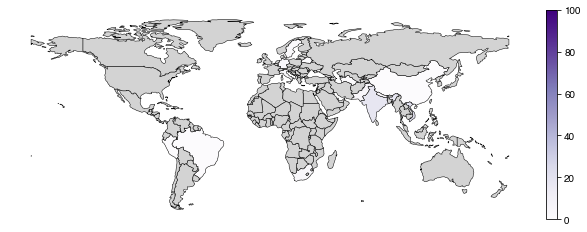

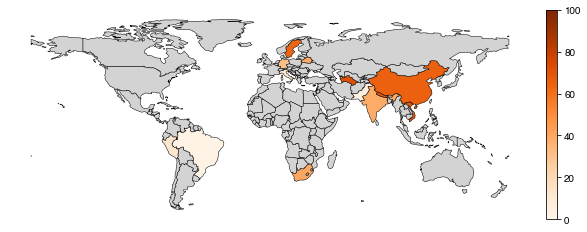

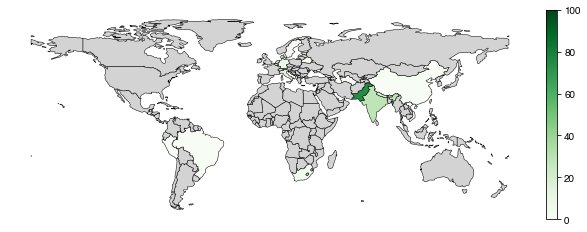

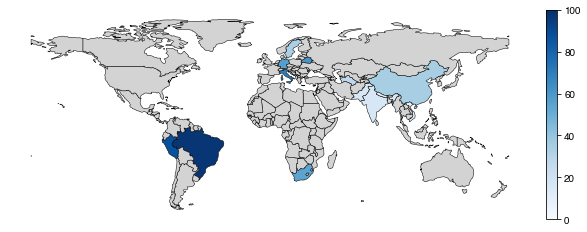

In [12]:
# first let's identify the countries which have at least 100 samples
SUBSET=UKMYC_PLATES.loc[(UKMYC_PLATES.TRUST_PHENOTYPES) & (UKMYC_PLATES.SPECIES=='M. tuberculosis')]
BIG_COUNTRY_LIST=SUBSET.COUNTRY_CODE.value_counts()
BIG_COUNTRY_LIST=BIG_COUNTRY_LIST[BIG_COUNTRY_LIST>100].to_frame()
BIG_COUNTRY_LIST.reset_index(inplace=True)
BIG_COUNTRY_LIST.rename(columns={'index':'COUNTRY_CODE','COUNTRY_CODE':'Number of samples'},inplace=True)

# this defines the lineages we will consider and also the colours used to plot them
Lineage_lookup={'Lineage 1':'Purples','Lineage 2':'Oranges','Lineage 3':'Greens','Lineage 4':'Blues'}

# now let's subset down to just these countries and Lineages 1-4 to avoid statistical blips
SUBSET=UKMYC_PLATES.loc[(UKMYC_PLATES.TRUST_PHENOTYPES) & (UKMYC_PLATES.SPECIES=='M. tuberculosis') & (UKMYC_PLATES.LINEAGE_NAME!='Lineage 6') & (UKMYC_PLATES.COUNTRY_CODE.isin(BIG_COUNTRY_LIST.COUNTRY_CODE.unique()))]
LINEAGE_COUNTRY=pandas.crosstab(SUBSET.COUNTRY_CODE,SUBSET.LINEAGE_NAME,normalize='index',margins=False)

# finally plot the choropleths
for lineage in Lineage_lookup:
    TABLE=100*LINEAGE_COUNTRY[lineage].to_frame()
    TABLE=TABLE.join(COUNTRIES_LOOKUP[['COUNTRY_NAME']])
    MAP=WORLD_MAP.join(TABLE,how='left')
    
    figure,axes = plt.subplots(figsize=(10,5))  

    divider=make_axes_locatable(axes)
    cax=divider.append_axes('right',size="2%",pad='1%')        

    MAP.plot(column=lineage,ax=axes,cmap=Lineage_lookup[lineage],edgecolor='black',cax=cax,linewidth=0.5,legend=True,missing_kwds= {'color':"lightgrey"},vmin=0,vmax=100)

    axes.set_axis_off()

    figure.savefig("graphs/map-"+lineage.lower()+".pdf",transparent=True)
    

# Table S5: *M. tuberculosis* lineage by country where collected 

In [13]:
SUBSET=copy.deepcopy(UKMYC_PLATES.loc[(UKMYC_PLATES.TRUST_PHENOTYPES) & (UKMYC_PLATES.BELONGS_GPI) & (UKMYC_PLATES.SPECIES=='M. tuberculosis') & (UKMYC_PLATES.LINEAGE_NAME!='Lineage 6')])
SUBSET.LINEAGE_NAME=SUBSET.LINEAGE_NAME.astype('object')
SUBSET.set_index('COUNTRY_CODE',inplace=True)
SUBSET=SUBSET.join(COUNTRIES_LOOKUP[['COUNTRY_NAME']],how='left')
SUBSET.reset_index(inplace=True)
SUBSET.rename(columns={'LINEAGE_NAME':'Lineage','COUNTRY_NAME':'Country'},inplace=True)
TABLE=pandas.crosstab(SUBSET.Country,SUBSET.Lineage,dropna=False,margins=True,margins_name='Total')
TABLE

Lineage,Lineage 1,Lineage 2,Lineage 3,Lineage 4,Total
Country,,,,,
Algeria,0,0,0,25,25
Belarus,0,40,0,62,102
Brazil,1,8,0,334,343
China,0,702,1,371,1074
Germany,25,218,60,400,703
India,261,581,425,239,1506
Italy,52,148,179,909,1288
Japan,0,0,0,1,1
Kyrgyzstan,0,25,0,3,28


# Figure S2: MIC distributions for the H37rV reference strain

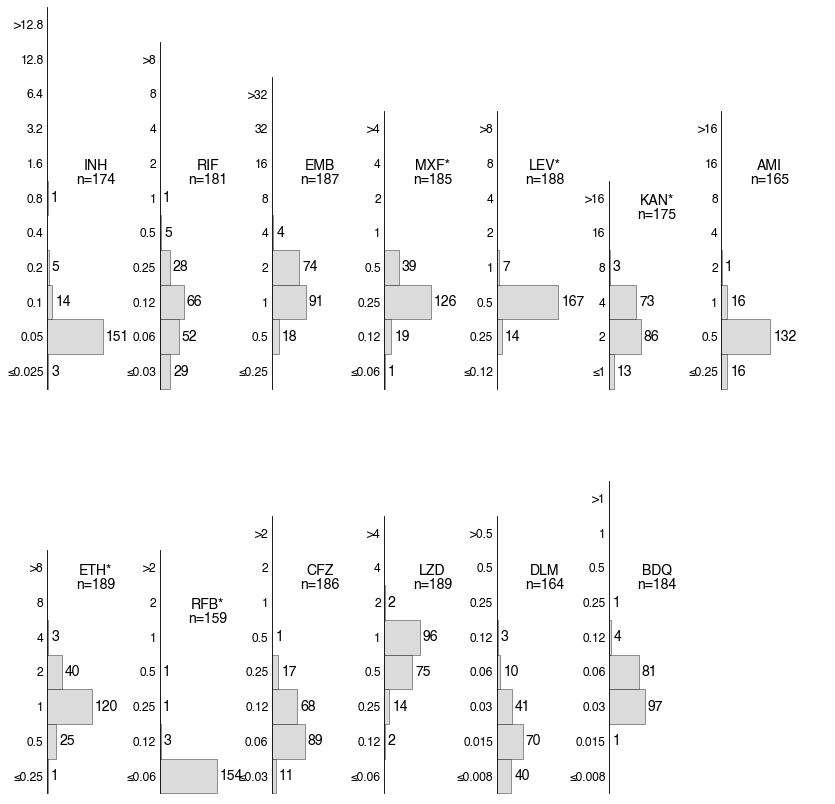

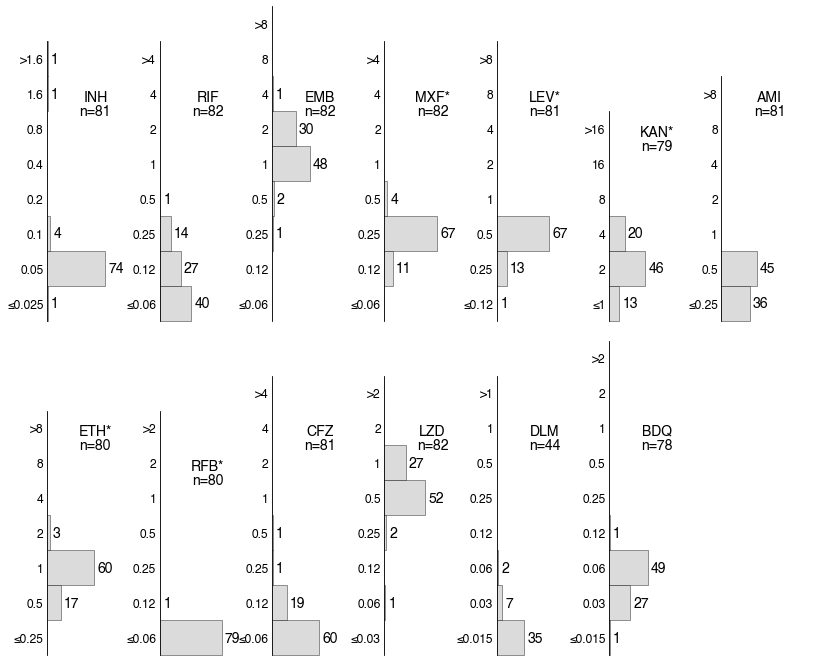

In [14]:
output_stem2='h37rv'

df=pandas.read_csv("tables/H37Rv.csv.gz")

for plate_design in plate_designs:
    cryptic_ecoffs.plot_histograms([plate_design],\
                                plate_design_lookup[plate_design],\
                                [df],\
                                plate_design,\
                                output_stem2,\
                                print_histogram=False,\
                                show_graph=True)


In [15]:
print("Data from "+str(len(df.SITEID.unique()))+" CRyPTIC laboratories have been pooled")

Data from 8 CRyPTIC laboratories have been pooled


# Table S6: H37Rv summary

Calculated by hand looking at the two H37Rv MIC histograms

# Figure S3: Proportions for MIC quality assurance workflow

In [16]:
df=copy.deepcopy(UKMYC_PHENOTYPES.loc[UKMYC_PHENOTYPES.PHENOTYPE_QUALITY!='MEDIUM'])
vz_im_agree=100*len(df[df.PHENOTYPE_DESCRIPTION=='VZ,IM AGREE'])/len(df)
vz_bb_agree=100*len(df[df.PHENOTYPE_DESCRIPTION=='VZ,BB AGREE'])/len(df[df.PHENOTYPE_DESCRIPTION!='VZ,IM AGREE'])
bb_im_agree=100*len(df[df.PHENOTYPE_DESCRIPTION=='BB,IM AGREE'])/len(df[df.PHENOTYPE_DESCRIPTION!='VZ,IM AGREE'])
all_disagree=100*len(df[df.PHENOTYPE_DESCRIPTION=='ALL DISAGREE'])/len(df[df.PHENOTYPE_DESCRIPTION!='VZ,IM AGREE'])
images_pass=100*len(df[df.PHENOTYPE_QUALITY=='HIGH'])/len(df)

print('For %.1f %% of all measurements the MICs measured by the laboratory scientist and AMyGDA were identical\n' % (vz_im_agree))
print('In %.1f %% of the images sent (%.1f %% of the total) the consensus MIC agreed with the MIC measured by the laboratory scientist using the Vizion instrument.\n' % (vz_bb_agree,vz_bb_agree*(100-vz_im_agree)/100))
print('For a smaller proportion (%.1f %% of the images completed by BashTheBug, %.1f %% of the total), the BashTheBug consensus agreed with the MIC measured by AMyGDA.\n' % (bb_im_agree,bb_im_agree*(100-vz_im_agree)/100))
print('Finally, no consensus could be reached in a significant minority (%.1f %% of the images completed by BashTheBug, %.1f %% of the total)\n' % (all_disagree,all_disagree*(100-vz_im_agree)/100))
print("Overall, %.1f %% of images pass the QA process.\n" % (images_pass))


For 54.7 % of all measurements the MICs measured by the laboratory scientist and AMyGDA were identical

In 38.1 % of the images sent (17.3 % of the total) the consensus MIC agreed with the MIC measured by the laboratory scientist using the Vizion instrument.

For a smaller proportion (12.0 % of the images completed by BashTheBug, 5.4 % of the total), the BashTheBug consensus agreed with the MIC measured by AMyGDA.

Finally, no consensus could be reached in a significant minority (49.9 % of the images completed by BashTheBug, 22.6 % of the total)

Overall, 77.4 % of images pass the QA process.



# Table S7. Variation(%) with antibiotic in the proportion of MICs where at least two methods agreed on the value.

In [17]:
BY_DRUG=copy.deepcopy(UKMYC_PHENOTYPES.loc[(UKMYC_PHENOTYPES.PHENOTYPE_QUALITY.isin(['LOW','HIGH']))] )
TABLE=(pandas.crosstab(BY_DRUG.DRUG,BY_DRUG.PHENOTYPE_QUALITY,margins=True,margins_name="Average",normalize='index').round(3)*100) 
TABLE=TABLE.replace("PHENOTYPE\_QUALITY","")
TABLE=TABLE.replace("LOW","Failed QA (\%)")
TABLE=TABLE.replace("HIGH","Passed QA (\%)")
TABLE=TABLE.replace("DRUG","Antibiotic")
TABLE

PHENOTYPE_QUALITY,HIGH,LOW
DRUG,,
AMI,81.1,18.9
BDQ,78.6,21.4
CFZ,73.3,26.7
DLM,76.0,24.0
EMB,67.1,32.9
ETH,81.0,19.0
INH,88.7,11.3
KAN,84.4,15.6
LEV,71.5,28.5


# Figure S4: Randomly selected images

Again done manually.

# Figure S5: raw MIC histograms

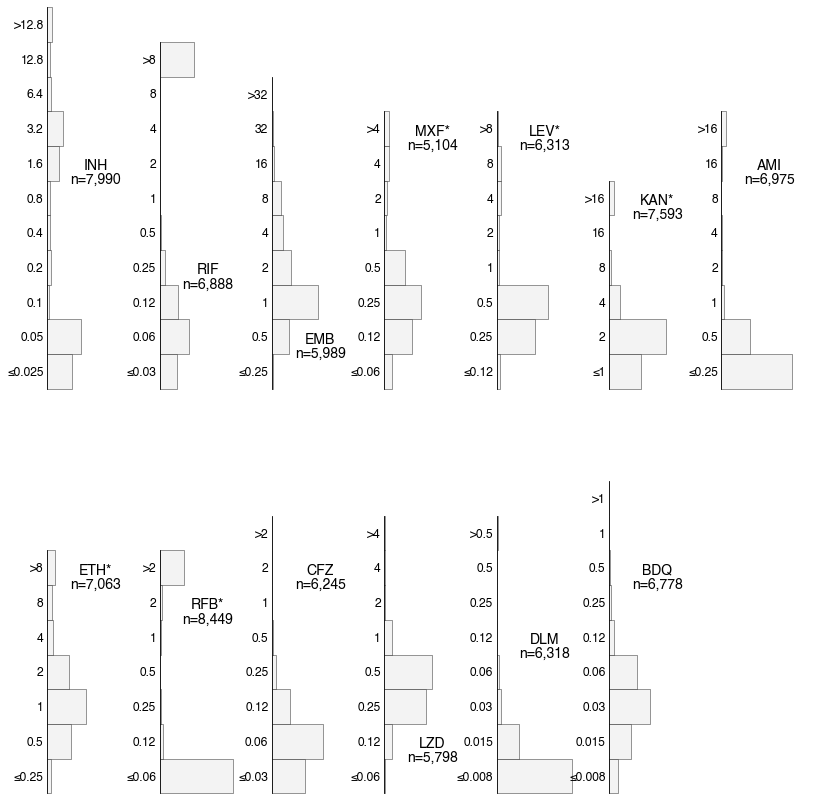

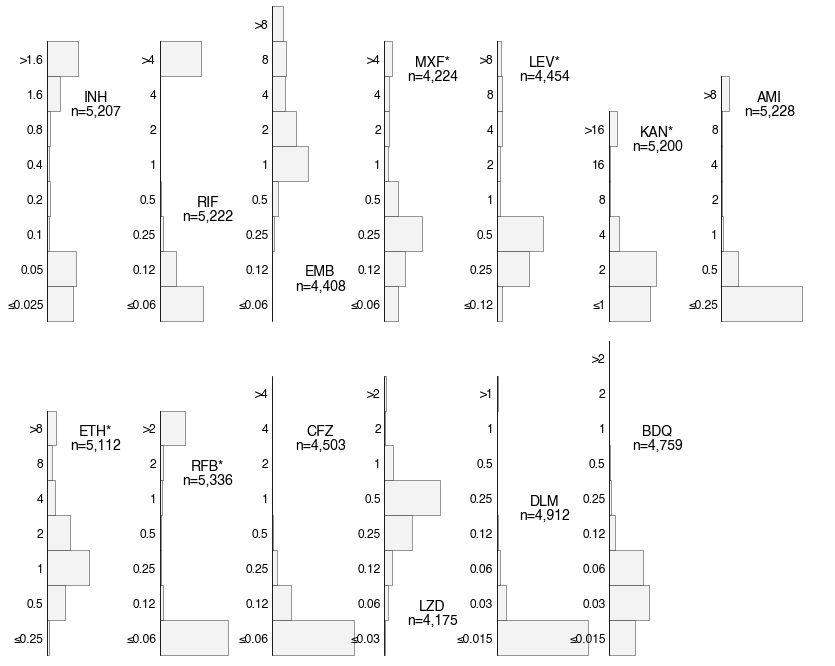

In [18]:
df=UKMYC_PHENOTYPES.loc[(UKMYC_PHENOTYPES.IS_RAW) & (UKMYC_PHENOTYPES.DILUTION>0)]
output_stem2='raw'
for plate_design in plate_designs:
    cryptic_ecoffs.plot_histograms([plate_design],\
                                plate_design_lookup[plate_design],\
                                [df],\
                                plate_design,\
                                output_stem2,\
                                bar_colour='#f0f0f0',
                                save_histogram=False,\
                                show_graph=True)    

# Figure 2 & S6 - ECOFFinder results on raw populations

A version of ECOFFinder provided by Claudio Köser (`ECOFFinderXL2011forMac.xlsx`) was used and the instructions followed. The results are recorded in `tables/ECOFFINDER-RESULTS.csv`. The same format as reported by Stata was used to allow for code reuse.

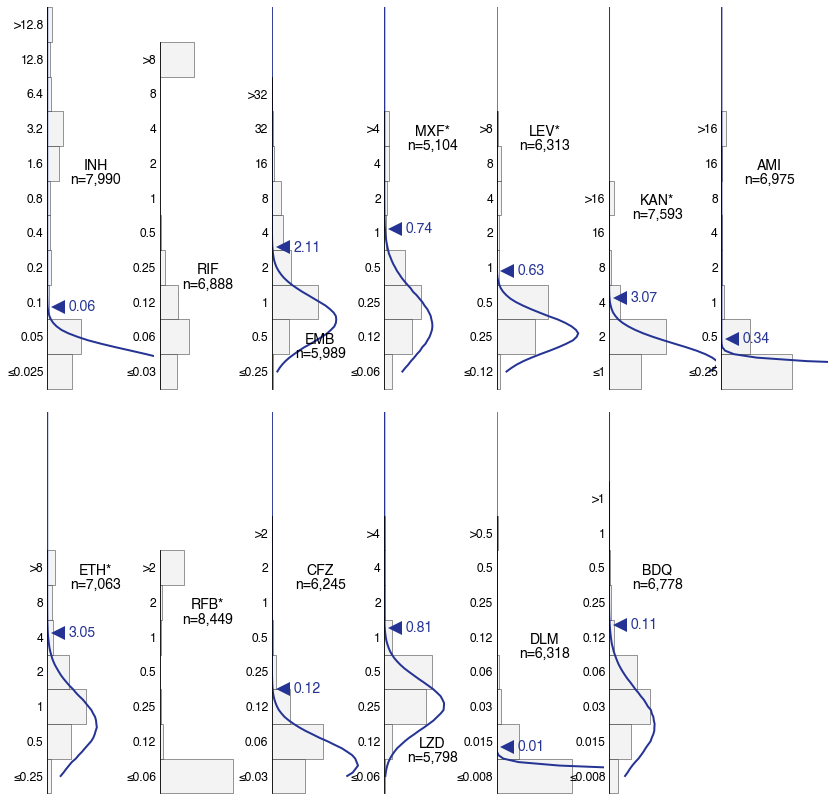

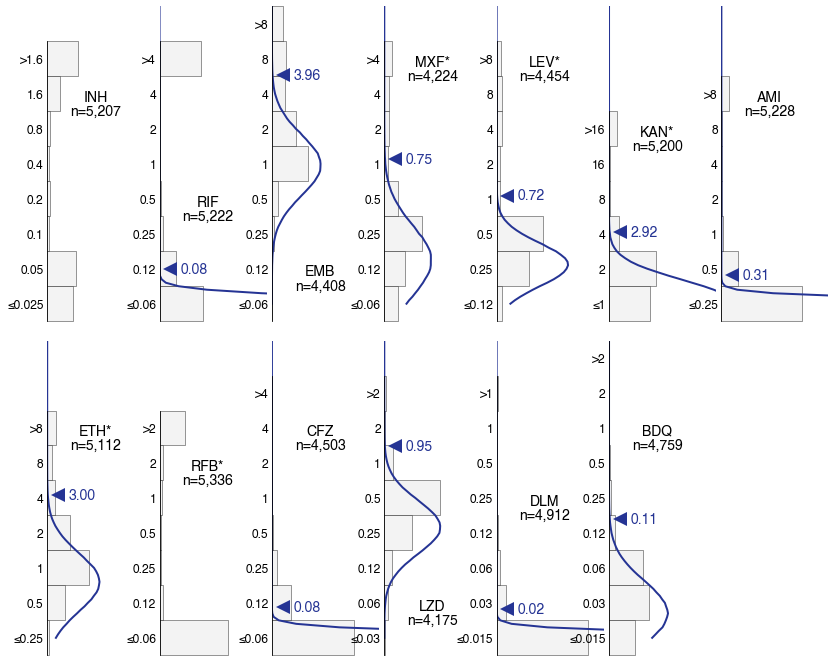

In [19]:
df=UKMYC_PHENOTYPES.loc[(UKMYC_PHENOTYPES.IS_RAW) & (UKMYC_PHENOTYPES.DILUTION>0)]

output_stem2='raw'
for plate_design in plate_designs:
    cryptic_ecoffs.plot_histograms([plate_design],\
                                plate_design_lookup[plate_design],\
                                [df],\
                                plate_design,\
                                output_stem2,\
                                plot_fitted_normal='ecoffinder',\
                                plot_components=1,\
                                plot_type="raw",\
                                ecoff_percentile=0.99,\
                                print_histogram=False,\
                                bar_colour='#f0f0f0',\
                                save_ecoff=False,\
                                show_graph=True)

A supplemental dataset containing the above histograms accompanies the manuscript; here we shall start building that dataset from the original data.

In [20]:
df=copy.deepcopy(UKMYC_PHENOTYPES.loc[(UKMYC_PHENOTYPES.IS_RAW) & (UKMYC_PHENOTYPES.DILUTION>0)])

# change MIC from category to object/string otherwise groupby misbehaves
df['MIC']=df['MIC'].astype('str')

# start collating the Supplemental Dataset that will provided along with the manuscript
supplemental_dataset=copy.deepcopy(df[['PLATEDESIGN','DRUG','MIC','SITEID']].groupby(['PLATEDESIGN','DRUG','MIC'],dropna=False).count())
supplemental_dataset.reset_index(inplace=True)
supplemental_dataset.rename(columns={'SITEID':'NUMBER_OF_SAMPLES'},inplace=True)
supplemental_dataset['RELEVANT_TO_FIGURE']=2
supplemental_dataset['POPULATION']="all samples"
supplemental_dataset[:7]

,PLATEDESIGN,DRUG,MIC,NUMBER_OF_SAMPLES,RELEVANT_TO_FIGURE,POPULATION
0,UKMYC5,AMI,0.5,833,2,all samples
1,UKMYC5,AMI,1,56,2,all samples
2,UKMYC5,AMI,2,17,2,all samples
3,UKMYC5,AMI,4,13,2,all samples
4,UKMYC5,AMI,8,13,2,all samples
5,UKMYC5,AMI,<=0.25,3940,2,all samples
6,UKMYC5,AMI,>8,356,2,all samples


# Figure S7 - interval regression with 2 log-normal distributions fitted to raw populations

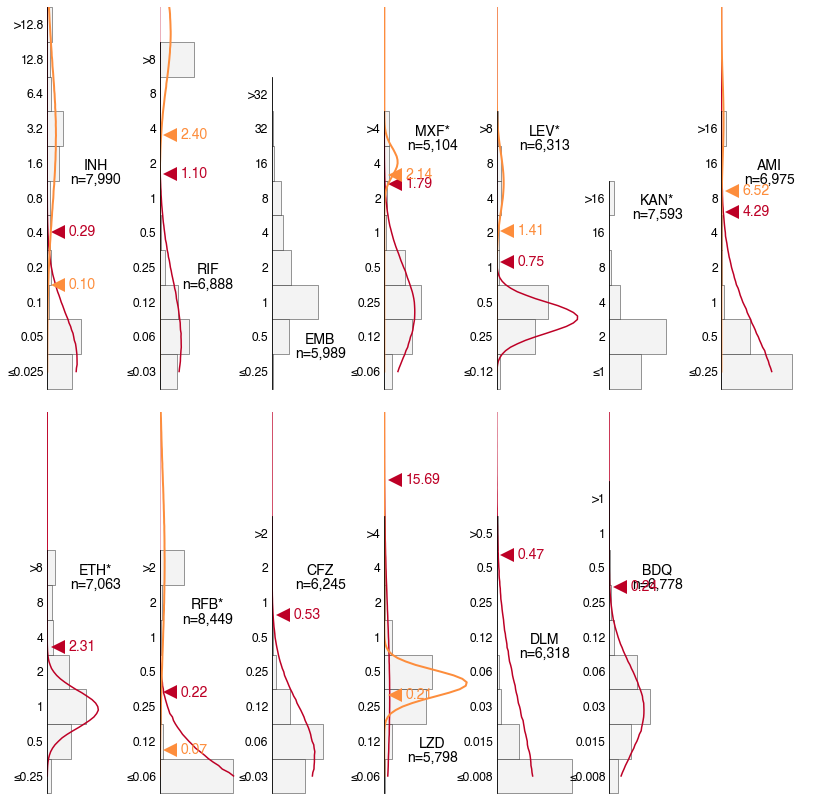

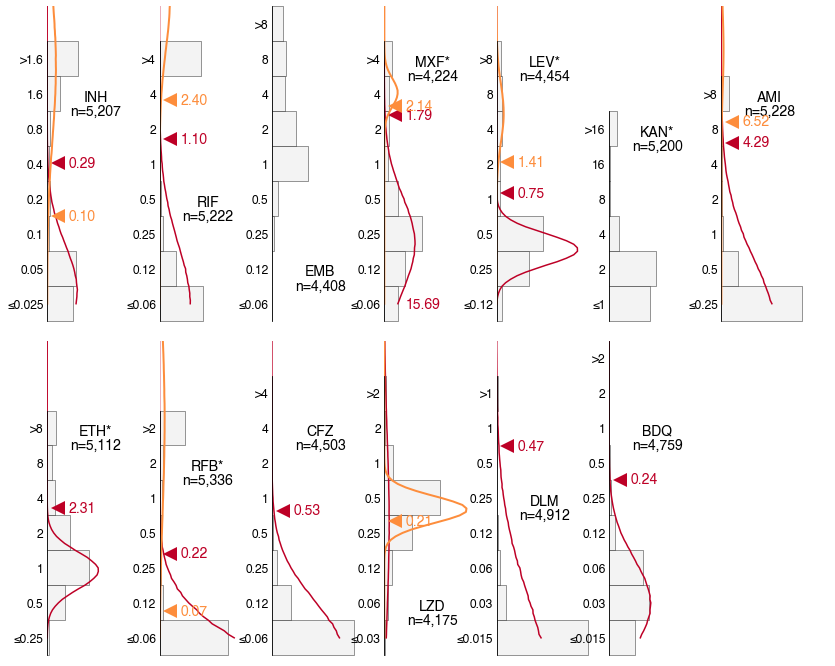

In [21]:
df=UKMYC_PHENOTYPES.loc[(UKMYC_PHENOTYPES.IS_RAW) & (UKMYC_PHENOTYPES.DILUTION>0)]
output_stem2='raw'
for plate_design in plate_designs:
    cryptic_ecoffs.plot_histograms([plate_design],\
                                plate_design_lookup[plate_design],\
                                [df],\
                                plate_design,\
                                output_stem2,\
                                plot_fitted_normal='intreg',\
                                plot_components=2,\
                                plot_type="raw",\
                                ecoff_percentile=0.99,\
                                print_histogram=False,\
                                bar_colour='#f0f0f0',\
                                show_graph=True)
    

# Table S8: Number of gWT samples by laboratory

In [22]:
df=UKMYC_PLATES.loc[(UKMYC_PLATES.TRUST_PHENOTYPES) &\
                    (UKMYC_PLATES.IM_WELLS_IDENTIFIED) &\
                    (~UKMYC_PLATES.DUPLICATED_IMAGE) &\
                    (UKMYC_PLATES.SITEID!='01') &\
                    (UKMYC_PLATES.index.isin(GENOMES.loc[GENOMES.IS_SSSSnotR_clean].index.unique()))]

df.reset_index(inplace=True)
df.set_index('SITEID',inplace=True)
SITES.reset_index(inplace=True)
SITES.set_index('SITEID',inplace=True)

df=df.join(SITES,how="left")
df.reset_index(inplace=True)
df.set_index('UNIQUEID',inplace=True)

df['Plate Design']=df.PLATEDESIGN
df['Laboratory']=df.DESCRIPTION
df['Location']=df.COUNTRY

TABLE=pandas.crosstab([df['Laboratory'],df['Location']],df['Plate Design'],margins=True,margins_name="Total")
TABLE

,Plate Design,UKMYC5,UKMYC6,Total
Laboratory,Location,,,
Brazil,Brazil,48,78,126
"Centre for Tuberculosis, NICD",South Africa,333,259,592
Chinese Center for Disease Control and Prevention,China,463,0,463
Hinduja Hospital and Foundation for Medical Research Mumbai,India,365,0,365
Institute of Microbiology and Laboratory Medicine,Germany,8,431,439
Oxford University Clinical Research Unit,Vietnam,370,156,526
San Raffaele Scientific Institute,Italy,109,302,411
Universidad Peruana Cayetano Heredia,Peru,354,685,1039
University of Capetown,South Africa,0,342,342


# Table S9: Number of gWT confirmed MICs by drug

In [23]:
df=UKMYC_PHENOTYPES.loc[(UKMYC_PHENOTYPES.index.isin(GENOMES.loc[GENOMES.IS_SSSSnotR_clean].index)) &\
                        (UKMYC_PHENOTYPES.IS_RAW) &\
                        (UKMYC_PHENOTYPES.DILUTION>0)]

TABLE=pandas.crosstab(df.DRUG,df.PLATEDESIGN,dropna=True,margins=True,margins_name='Total')

# remove the bottom summation
TABLE=TABLE.loc[TABLE.index!='Total']

TABLE

PLATEDESIGN,UKMYC5,UKMYC6,Total
DRUG,,,
AMI,1840,1667,3507
BDQ,1666,1631,3297
CFZ,1586,1414,3000
DLM,1687,1361,3048
EMB,1505,1354,2859
ETH,1832,1680,3512
INH,1813,1890,3703
KAN,1834,1790,3624
LEV,1587,1447,3034


In [24]:
TABLE.Total.min(),TABLE.Total.max(), round(TABLE.Total.mean())

(2594, 4078, 3263)

# Figure S8 - clean MIC histograms for SSSSnotRclean population with interval regression

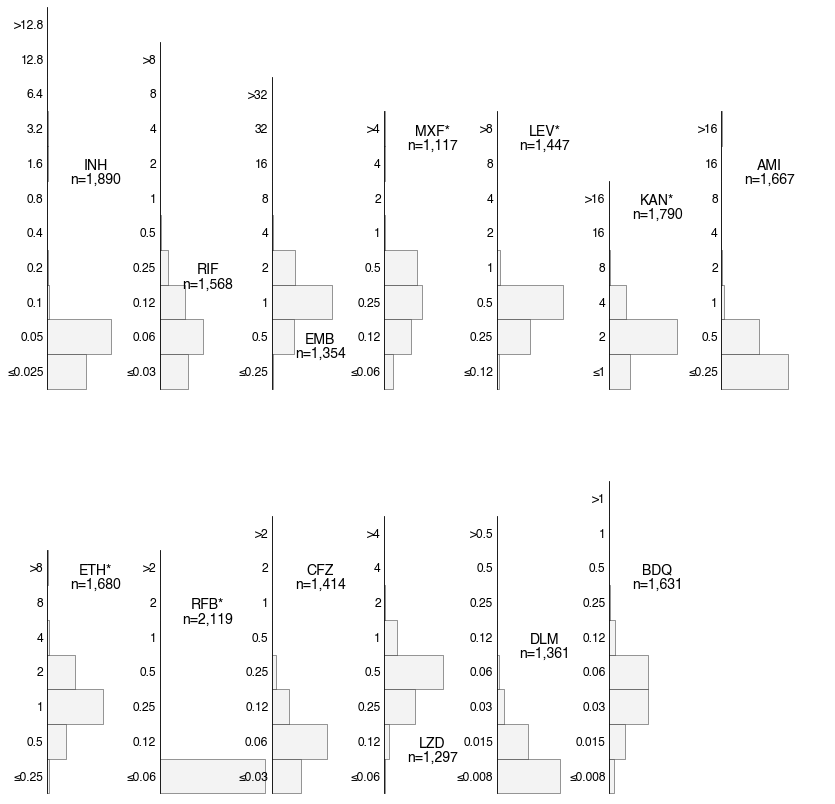

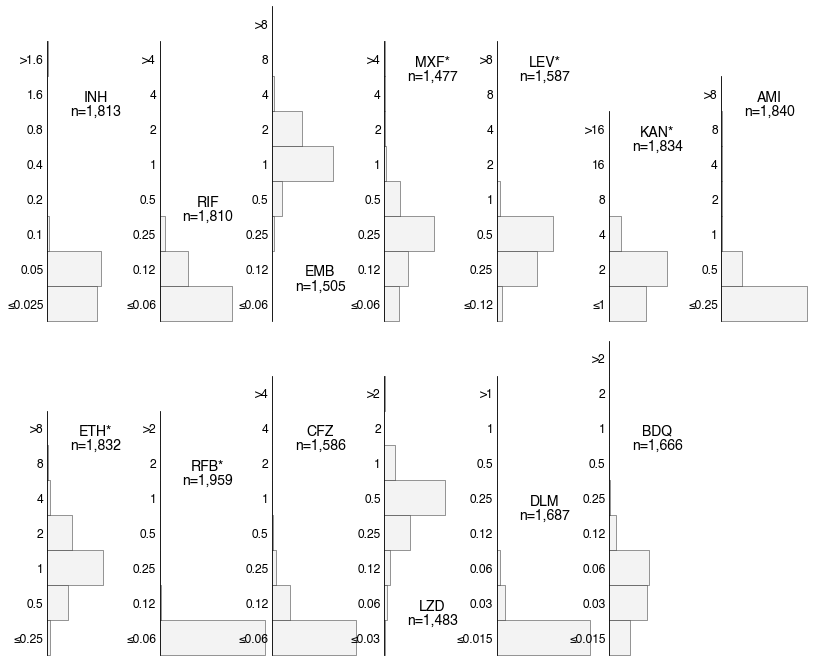

In [25]:
df=UKMYC_PHENOTYPES.loc[(UKMYC_PHENOTYPES.index.isin(GENOMES.loc[GENOMES.IS_SSSSnotR_clean].index)) &\
                        (UKMYC_PHENOTYPES.IS_RAW) &\
                        (UKMYC_PHENOTYPES.DILUTION>0)]

output_stem2='SSSSnotRclean'

for plate_design in plate_designs:

    cryptic_ecoffs.plot_histograms([plate_design],\
                                plate_design_lookup[plate_design],\
                                [df],\
                                plate_design,\
                                output_stem2,\
                                save_histogram=False,\
                                bar_colour='#f0f0f0',\
                                show_graph=True)

# Figure 3, S9 - Direct estimation from SSSSnotRclean population

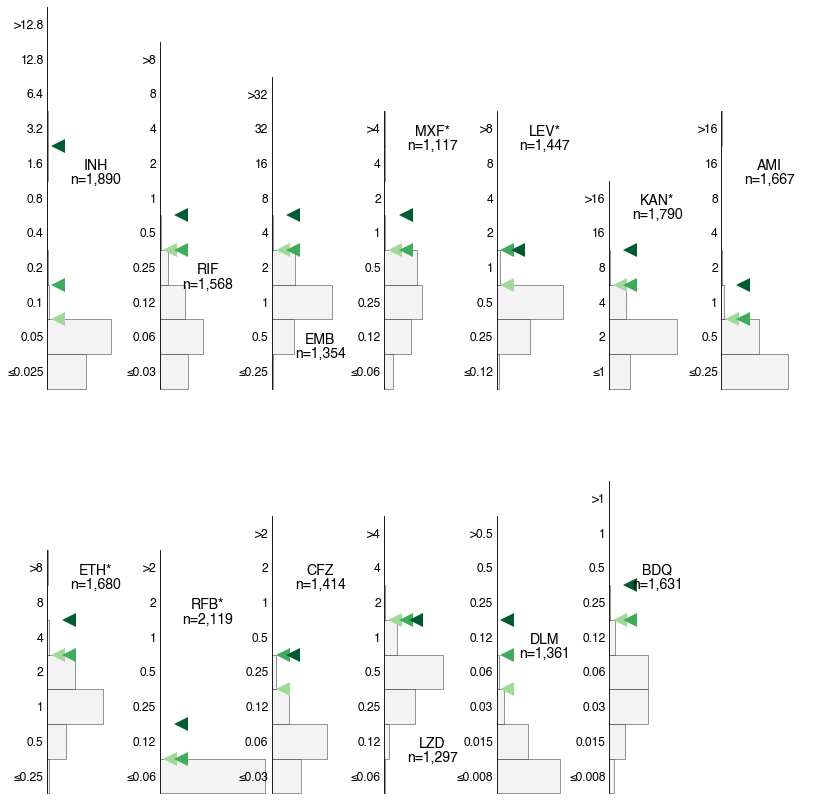

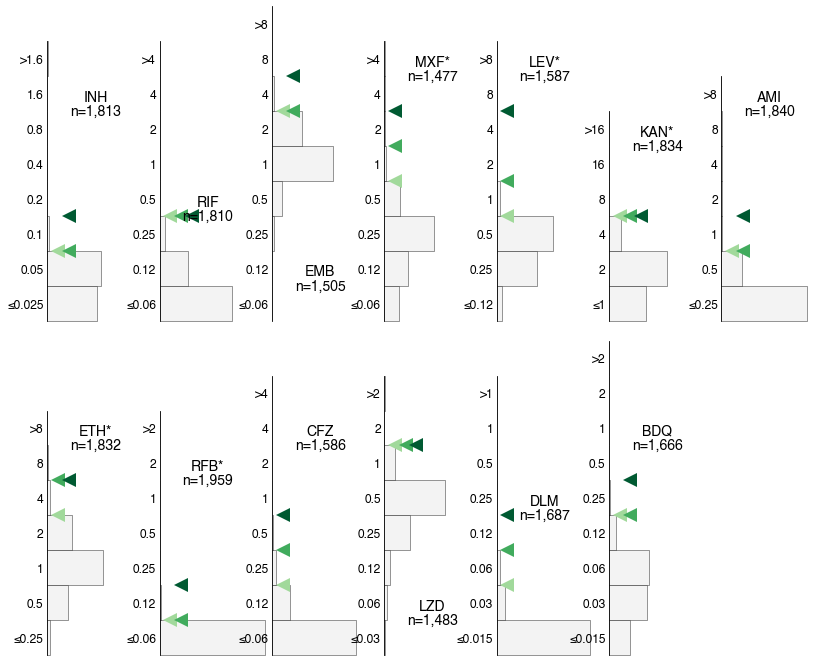

In [26]:
df=UKMYC_PHENOTYPES.loc[(UKMYC_PHENOTYPES.index.isin(GENOMES.loc[GENOMES.IS_SSSSnotR_clean].index)) &\
                        (UKMYC_PHENOTYPES.IS_RAW) &\
                        (UKMYC_PHENOTYPES.DILUTION>0)]

output_stem2='SSSSnotRclean'

for plate_design in plate_designs:

    cryptic_ecoffs.plot_histograms([plate_design],\
                                plate_design_lookup[plate_design],\
                                [df],\
                                plate_design,\
                                output_stem2,\
                                plot_fitted_normal='direct',\
                                plot_type=output_stem2,\
                                ecoff_percentile=0.99,\
                                print_histogram=False,\
                                print_direct=False,
                                bar_colour='#f0f0f0',\
                                show_graph=True)

Now append the above gWT histograms to the supplemental dataset that accompanies the manuscript.

In [27]:
# change MIC from category to object/string otherwise groupby misbehaves
# df['MIC']=df['MIC'].astype('str')
df = copy.deepcopy(df.astype({'MIC':'str'}))

# do the groupby
supplemental_dataset2=df[['PLATEDESIGN','DRUG','MIC','SITEID']].groupby(['PLATEDESIGN','DRUG','MIC'],dropna=False).count()
supplemental_dataset2.reset_index(inplace=True)
supplemental_dataset2.rename(columns={'SITEID':'NUMBER_OF_SAMPLES'},inplace=True)
supplemental_dataset2['RELEVANT_TO_FIGURE']=3
supplemental_dataset2['POPULATION']='genotypically wild-type'
supplemental_dataset2[:7]

supplemental_dataset=pandas.concat([supplemental_dataset,supplemental_dataset2])
supplemental_dataset=supplemental_dataset[['RELEVANT_TO_FIGURE',
       'POPULATION','PLATEDESIGN', 'DRUG', 'MIC', 'NUMBER_OF_SAMPLES']]
supplemental_dataset[['RELEVANT_TO_FIGURE','PLATEDESIGN','DRUG','NUMBER_OF_SAMPLES']].groupby(['RELEVANT_TO_FIGURE','PLATEDESIGN','DRUG']).sum()
supplemental_dataset.to_csv('cryptic-ECOFFs-supplemental-data.tsv',index=False,sep = '\t')

# Figure 4, S10 - Fitting log-normal distributions to the SSSSnotRclean population using interval regression

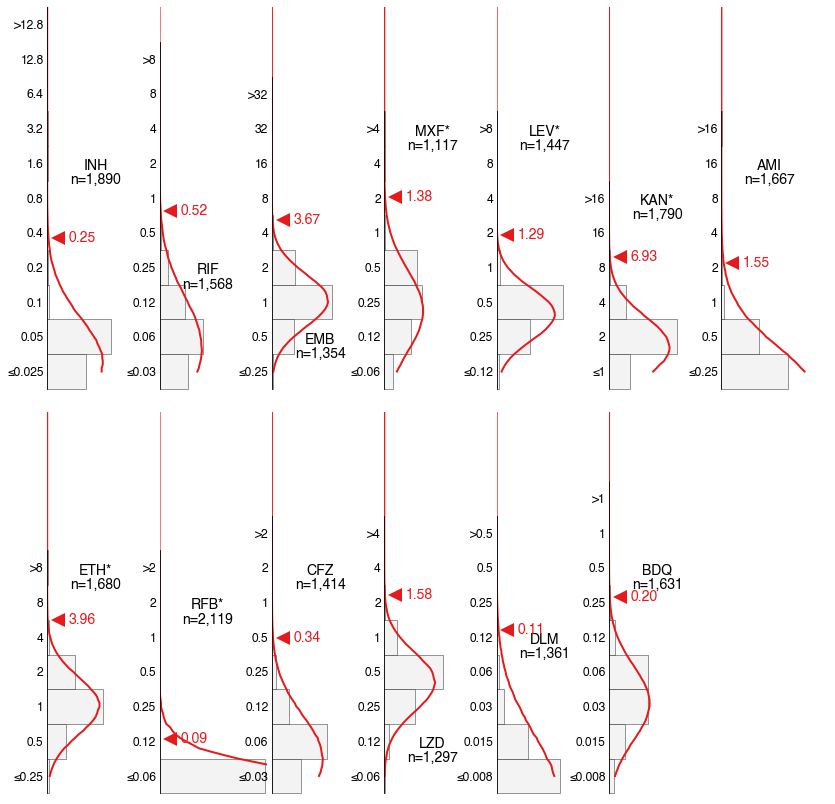

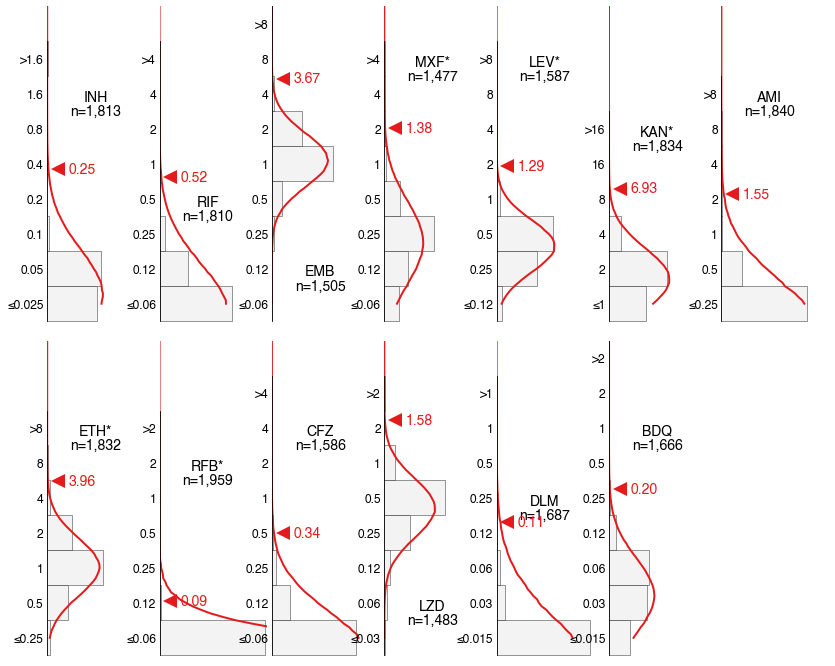

In [28]:
df=UKMYC_PHENOTYPES.loc[(UKMYC_PHENOTYPES.index.isin(GENOMES.loc[GENOMES.IS_SSSSnotR_clean].index)) &\
                        (UKMYC_PHENOTYPES.IS_RAW) &\
                        (UKMYC_PHENOTYPES.DILUTION>0)]

output_stem2='SSSSnotRclean'

for plate_design in plate_designs:

    cryptic_ecoffs.plot_histograms([plate_design],\
                                plate_design_lookup[plate_design],\
                                [df],\
                                plate_design,\
                                output_stem2,\
                                plot_fitted_normal='intreg',\
                                plot_components=1,\
                                plot_type=output_stem2,\
                                ecoff_percentile=0.99,\
                                bar_colour='#f0f0f0',\
                                print_histogram=False,\
                                show_graph=True)
    

# Figure 5

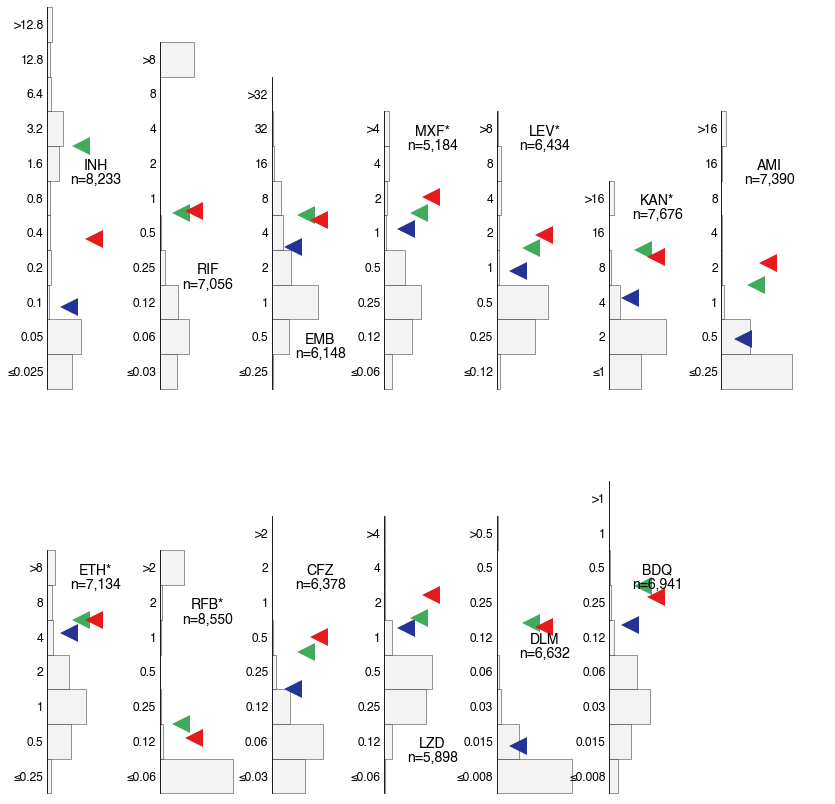

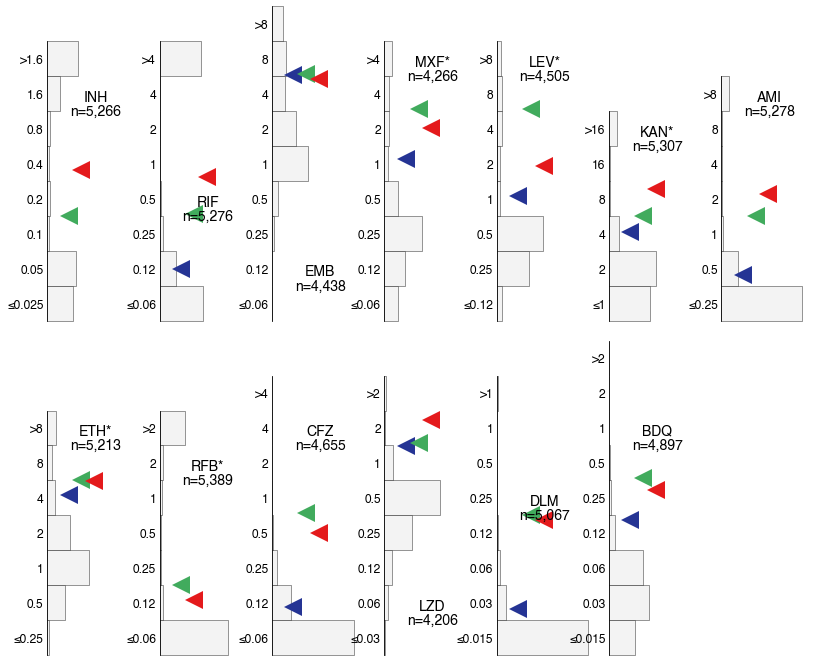

In [29]:
df=UKMYC_PHENOTYPES.loc[UKMYC_PHENOTYPES.IS_RAW]

for plate_design in plate_designs:
    cryptic_ecoffs.plot_histograms([plate_design],\
                                plate_design_lookup[plate_design],\
                                [df],\
                                plate_design,\
                                'raw-summary',\
                                bar_colour='#f0f0f0',\
                                save_histogram=False,\
                                show_graph=True,
                                plot_fitted_normal='summary',\
                                plot_type="raw")

# Figure 6, S11

In [30]:
PLATE_LAYOUT.reset_index(inplace=True)

In [31]:
variants_lookup = {'INH':['katG@S315T','fabG1@c-15t','fabG1@g-17t','fabG1@L203L'],\
                   'RIF':['rpoB@S450L','rpoB@D435V'],\
                   'EMB':['embB@M306V','embB@M306I'],\
                   'MXF':['gyrA@D94G','gyrA@A90V'],\
                   'LEV':['gyrA@D94G','gyrA@A90V'],\
                   'KAN':['rrs@a1401g'],\
                   'AMI':['rrs@a1401g'],\
                   'ETH':['fabG1@c-15t','fabG1@g-17t','fabG1@L203L'],\
                   'RFB':['rpoB@S450L'],\
                   'CFZ':[],\
                   'LZD':[]
                  }

print("%6s %7s %14s %5s %5s %5s" % ('DRUG','PLATE','DESC','S','I','R'))

for plate_design in ['UKMYC6','UKMYC5']:

    for drug_name in variants_lookup:

        y_max=PLATE_LAYOUT.loc[PLATE_LAYOUT.PLATEDESIGN==plate_design].DILUTION.max()+0.5
        
        PLATE_PHENOTYPES=UKMYC_PHENOTYPES.loc[(UKMYC_PHENOTYPES.IS_RAW) &\
                                              (UKMYC_PHENOTYPES.DILUTION>0) &\
                                              (UKMYC_PHENOTYPES.PLATEDESIGN==plate_design) &\
                                              (UKMYC_PHENOTYPES.BELONGS_GPI) &\
                                              (UKMYC_PHENOTYPES.DRUG==drug_name)]

        layout=copy.deepcopy(PLATE_LAYOUT.loc[(PLATE_LAYOUT.PLATEDESIGN==plate_design) &\
                                              (PLATE_LAYOUT.DRUG==drug_name)] )        
        layout.sort_values('DILUTION',inplace=True)
        
        bins=range(0,12,1)
        (values,dil)=numpy.histogram(PLATE_PHENOTYPES.DILUTION,bins)

        x_max=max(values)
        x_max=int(1.02*x_max)

        figure,axes = plt.subplots(1,1,figsize=(1.5,6))

        axes=cryptic_ecoffs.plot_mic_histogram( axes,
                                              PLATE_PHENOTYPES.DILUTION,
                                              drug_name=drug_name,
                                              conc_table=layout,
                                              colour='#f0f0f0',
                                              label_values=False, #True
                                              label_drug=False,
                                              label_N=False,
                                              label_yaxis=True,
                                              label_xaxis=False,
                                              max_label_value=2000,
                                              x_max=x_max, #chgange back to x_max
                                              y_max=y_max,
                                              normed=False,
                                              axis_fontsize=9,
                                              label_fontsize=14)

        figure.savefig("graphs/hist-"+drug_name+"-"+plate_design+"-raw.pdf",bbox_inches='tight',transparent=True)

        plt.close()
        
        df=PLATE_PHENOTYPES.BINARY_PHENOTYPE.value_counts()    
        n={}
        for i in ['S','I','R']:
            if i in df.index:
                n[i]=df[i]
            else:
                n[i]=0

        print("%6s %7s %14s %5i %5i %5i" % (drug_name,plate_design,'raw',int(n['S']),n['I'],n['R']))
        
        for variant in variants_lookup[drug_name]:
            
            (gene,mutation)=variant.split('@')
            
            MUTS=MUTATIONS.loc[(MUTATIONS.GENE==gene) & (MUTATIONS.MUTATION==mutation)]
            
            ALL=PLATE_PHENOTYPES.join(MUTS[['NUMBER_NUCLEOTIDE_CHANGES']],how='inner')
            
            figure,axes = plt.subplots(1,1,figsize=(1.5,6))
                        
            df=ALL.BINARY_PHENOTYPE.value_counts()

            n={}
            for i in ['S','I','R']:
                if i in df.index:
                    n[i]=df[i]
                else:
                    n[i]=0
                            
            print("%6s %7s %14s %5i %5i %5i" % (drug_name,plate_design,variant,int(n['S']),n['I'],n['R']))

    
            axes=cryptic_ecoffs.plot_mic_histogram( axes,
                                                  ALL.DILUTION,
                                                  drug_name=drug_name,
                                                  conc_table=layout,
                                                  colour='#ef6548',
                                                  label_values=False, #True
                                                  label_drug=False,
                                                  label_N=False,
                                                  label_yaxis=False,
                                                  label_xaxis=False,
                                                  max_label_value=2000,
                                                  x_max=x_max, #chgange back to x_max
                                                  y_max=y_max,
                                                  normed=False,
                                                  axis_fontsize=9,
                                                  label_fontsize=7)

            figure.savefig("graphs/hist-"+drug_name+"-"+plate_design+"-"+gene+"-"+mutation+".pdf",bbox_inches='tight',transparent=True)
            
            plt.close()
        
        print()
            

  DRUG   PLATE           DESC     S     I     R
   INH  UKMYC6            raw  2525   303  1895
   INH  UKMYC6     katG@S315T     8     6  1665
   INH  UKMYC6    fabG1@c-15t     3   199   211
   INH  UKMYC6    fabG1@g-17t     1    22    91
   INH  UKMYC6    fabG1@L203L     0    13    32

   RIF  UKMYC6            raw  2634     0  1488
   RIF  UKMYC6     rpoB@S450L    32     0   991
   RIF  UKMYC6     rpoB@D435V    13     0   161

   EMB  UKMYC6            raw  2533   387   478
   EMB  UKMYC6     embB@M306V    21    99   168
   EMB  UKMYC6     embB@M306I    61   125   122

   MXF  UKMYC6            raw  2517     0   361
   MXF  UKMYC6      gyrA@D94G    21     0   141
   MXF  UKMYC6      gyrA@A90V    38     0    53

   LEV  UKMYC6            raw  3219     0   440
   LEV  UKMYC6      gyrA@D94G    18     0   163
   LEV  UKMYC6      gyrA@A90V     9     0    88

   KAN  UKMYC6            raw  4170     0   342
   KAN  UKMYC6     rrs@a1401g    23     0   224

   AMI  UKMYC6            raw  390

# Figure 7, S12, S13, Tables S10, S11. Validation against MGIT/MODS

In [32]:
def plot_heatmap(array,measurement_method,drug,ytics,xtics):
    fig = plt.figure(figsize=(1*array.shape[1],1*array.shape[0]))
    plt.tight_layout()
    ax=fig.gca()
    ax.set_title(drug)        
    ax.imshow(array, interpolation='nearest',norm=colors.PowerNorm(gamma=2./5.),cmap='PuRd')
    ax.set_xticks(range(array.shape[1]))
    ax.set_xticklabels(xtics)
    ax.set_yticks(range(array.shape[0]))
    ax.set_yticklabels(ytics)
    # label each cell if there is sufficient data
    for i in range(array.shape[1]):
        for j in range(array.shape[0]):
            if array[(j,i)] > 50:
                ax.text(i,j,str("%d" % (array[(j,i)])),horizontalalignment='center',verticalalignment='center',color='white',size='large',weight="bold")
            elif array[(j,i)] < 50:
                ax.text(i,j,str("%d" % (array[(j,i)])),horizontalalignment='center',verticalalignment='center',color='black',size='large')

        
        fig.savefig("graphs/heatmap-"+measurement_method+"-"+drug+".pdf",transparent=True)
    plt.close(fig)

for measurement_method in ['MODS','MGIT960']:

    TABLE=[]
    
    for drug_name in ['INH','RIF','EMB','MXF','LEV','KAN','AMI','ETH','LZD','CFZ']:

        PLATE_PHENOTYPES=UKMYC_PHENOTYPES.loc[(UKMYC_PHENOTYPES.IS_RAW) &\
                                              (UKMYC_PHENOTYPES.DILUTION>0) &\
                                              (UKMYC_PHENOTYPES.DRUG==drug_name)]

        if drug_name=='MXF':
            MGIT_PHENOTYPES=DST_MEASUREMENTS.loc[(DST_MEASUREMENTS.DRUG==drug_name) &\
                                                 (DST_MEASUREMENTS.METHOD_3==measurement_method) &\
                                                 (DST_MEASUREMENTS.METHOD_CC==0.5)]
        else:
            MGIT_PHENOTYPES=DST_MEASUREMENTS.loc[(DST_MEASUREMENTS.DRUG==drug_name) &\
                                                 (DST_MEASUREMENTS.METHOD_3==measurement_method)]

        ALL=PLATE_PHENOTYPES.join(MGIT_PHENOTYPES[['PHENOTYPE']],how='inner')

        ALL=ALL.loc[(ALL.PHENOTYPE.notna()) & (ALL.BINARY_PHENOTYPE.notna())]
        
        if len(ALL)>0:
        
            z=pandas.pivot_table(ALL,index="BINARY_PHENOTYPE",columns="PHENOTYPE",values="PRIMARY_DILUTION",aggfunc=len)

            if "I" in z.index:
                z=z.reindex(['R','I','S'],axis=0)
            if "I" in z.columns:
                z=z[["S","I","R"]]
            else:
                z=z[["S","R"]]

            y_tics=list(z.columns)
            x_tics=list(z.index)

            sens=z['R']['R']/(z['R']['R']+z['R']['S'])
            spec=z['S']['S']/(z['S']['S']+z['S']['R'])
            categorical_agreement=(z['R']['R']+z['S']['S'])/(z['R']['R']+z['S']['S']+z['R']['S']+z['S']['R'])
            md=z['S']['R']/(z['S']['R']+z['S']['S'])
            vmd=z['R']['S']/(z['R']['S']+z['R']['R'])
            
            TABLE.append([drug_name,len(ALL),100*sens,100*spec,100*categorical_agreement,100*vmd,100*md])
            plot_heatmap(z.values,measurement_method,drug_name,x_tics,y_tics)

    TABLE=pandas.DataFrame(TABLE,columns=['Drug','Number of samples','Sensitivity (%)','Specificity (%)','Categorical agreement (%)','MD (%)','VMD (%)'])
    TABLE=TABLE.round({'Sensitivity (%)':1,'Specificity (%)':1,'Categorical agreement (%)':1,'MD (%)':1,'VMD (%)':1})
    if measurement_method=='MGIT960':
        print("Comparing the binary phenotypes derived from a UKMYC plate results to MGIT960")
    else:
        print("Comparing the binary phenotypes derived from a UKMYC plate results to MODS")
    print(TABLE) 

Comparing the binary phenotypes derived from a UKMYC plate results to MODS
  Drug  Number of samples  Sensitivity (%)  Specificity (%)  \
0  INH               1888             95.3             98.9   
1  RIF               1857             95.1             99.2   

   Categorical agreement (%)  MD (%)  VMD (%)  
0                       97.8     4.7      1.1  
1                       98.2     4.9      0.8  
Comparing the binary phenotypes derived from a UKMYC plate results to MGIT960
  Drug  Number of samples  Sensitivity (%)  Specificity (%)  \
0  INH               1516             93.4             97.0   
1  RIF               1456             96.5             96.6   
2  EMB                961             91.4             91.9   
3  LEV                106             97.9             83.1   
4  KAN               1262             76.2             99.1   
5  AMI               1175             84.3             99.3   
6  ETH                954             63.0             97.0   
7  LZD   